In [1]:
from SLCP.datasets import datasets
from SLCP.cqr import helper
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from ACP.acv_explainers import ACXplainer
from ACP.acv_explainers.utils import mean_score, quantile_score
from SLCP.conformal import ConformalPred
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

/home/xxxxx/anaconda3/envs/acv3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Import datasets

In [2]:
random_seed = 2022

base_dataset_path = '/home/xxxxx/acp_experiments/SLCP/datasets/'
dataset_name = 'bike'

test_ratio = 0.25
valid_ratio = 0.5

alpha = 0.1
level = 1 - alpha

# METRICS
coverages = {}
lengths = {}
lengths_residuals = {}
y_lower = {}
y_upper = {}
r = {}

In [3]:
X_train, X_test, y_train, y_test = datasets.GetDataset(dataset_name, base_dataset_path, random_seed, test_ratio)

x_train, x_test = X_train.astype(np.double), X_test.astype(np.double)
y_train, y_test = y_train.astype(np.double).reshape(-1), y_test.astype(np.double).reshape(-1)

in_shape = x_train.shape[1]
n_train = x_train.shape[0]

idx = np.random.permutation(n_train)
n_half = int(np.floor(n_train * valid_ratio))
idx_train, idx_cal = idx[:n_half], idx[n_half:]

### 2. Train model

In [4]:
mean_estimator = RandomForestRegressor(n_estimators=100,
                                       min_samples_leaf=10,
                                       max_features=10,
                                       random_state=random_seed)

mean_estimator.fit(x_train[idx_train], y_train[idx_train])

RandomForestRegressor(max_features=10, min_samples_leaf=10, random_state=2022)

In [5]:
pred_mean = mean_estimator.predict(x_test).astype(np.float64)
v_test = mean_score(pred_mean, y_test)

### 3. Adaptive Conformal Prediction (ACP) 

In [6]:
acp = ACXplainer(classifier=False, n_estimators=100,
                  mtry=int(in_shape),
                  max_depth=20,
                  min_node_size=10,
                  seed=random_seed)

In [7]:
acp.fit_calibration(x_train[idx_cal], y_train[idx_cal], mean_estimator, quantile=level, only_qrf=True)

Training calibration of QRF


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:37<00:00,  1.95s/it]


In [8]:
# These code first compute the predicted residuals quantile, then compute the PI
r['QRF_TC'] = acp.predict_qrf_r(x_test)
y_lower['QRF_TC'] = pred_mean - r['QRF_TC']
y_upper['QRF_TC'] = pred_mean + r['QRF_TC']
# You can compute directly the PI 
# y_lower, y_upper = acv.predict_qrf_pi(x_test)

### 4. Split Conformal Prediciton 

In [9]:
# SPLIT conformal
cp_split = ConformalPred(model=mean_estimator,
                         method='split',
                         data_name=dataset_name,
                         ratio=valid_ratio,
                         x_train=x_train,
                         x_test=x_test,
                         y_train=y_train,
                         y_test=y_test)

cp_split.idx_train = idx_train
cp_split.idx_cal = idx_cal
cp_split.fit()

y_lower_split, y_upper_split = cp_split.predict()
y_lower['SPLIT'] = y_lower_split
y_upper['SPLIT'] = y_upper_split
r['SPLIT'] = y_upper_split - y_lower_split

### 5. SLCP 

In [10]:
cp_slcp = ConformalPred(model=mean_estimator,
                                method='slcp-mean',
                                data_name=dataset_name,
                                ratio=valid_ratio,
                                x_train=x_train,
                                x_test=x_test,
                                y_train=y_train,
                                y_test=y_test)

cp_slcp.idx_train = idx_train
cp_slcp.idx_cal = idx_cal
cp_slcp.fit()


y_lower_slcp, y_upper_slcp = cp_slcp.predict()
y_lower['SLCP'] = y_lower_slcp
y_upper['SLCP'] = y_upper_slcp
r['SLCP'] = y_upper_slcp - y_lower_slcp

###  Metrics

In [11]:
methods = ['QRF_TC', 'SPLIT', 'SLCP']

In [12]:
for method in methods:
    coverages[method], lengths[method] = helper.compute_coverage(y_test, y_lower[method], y_upper[method],
                                                                 alpha, method)
    lengths_residuals[method] = np.mean(np.abs(v_test - r[method]))


QRF_TC: Percentage in the range (expecting 90.00): 90.668626
QRF_TC: Average length: 165.801103
SPLIT: Percentage in the range (expecting 90.00): 90.264511
SPLIT: Average length: 232.805553
SLCP: Percentage in the range (expecting 90.00): 90.080823
SLCP: Average length: 233.048931


In [13]:
r_data = pd.DataFrame.from_dict(r)

v_error = r_data.copy()
for method in methods:
    v_error[method] = np.abs(v_error[method] - v_test)/np.abs(v_test) 

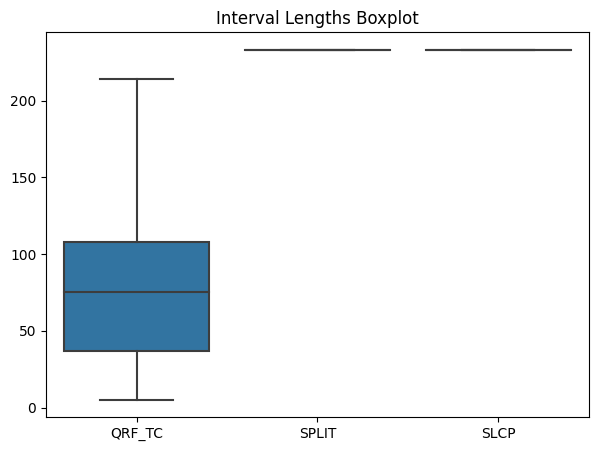

In [14]:
fig, ax = plt.subplots(dpi=100, figsize=(7, 5))
g = sns.boxplot(data=r_data[methods], orient="v", ax=ax, showfliers = False,
           saturation=0.75, width=0.8, dodge=True, fliersize=5, linewidth=None, whis=1.5)
g.set_title('Interval Lengths Boxplot')
plt.show()

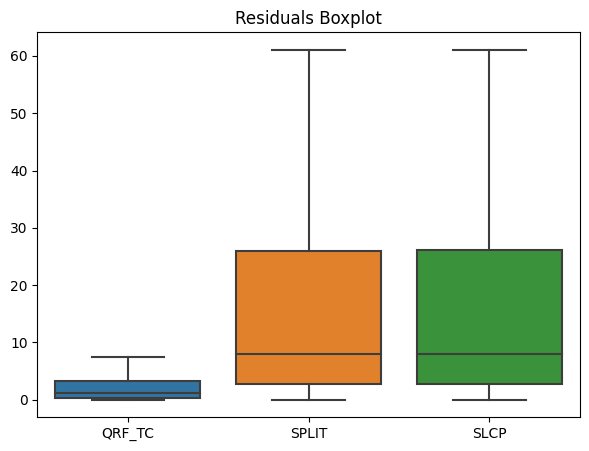

In [15]:
fig, ax = plt.subplots(dpi=100, figsize=(7, 5))
g = sns.boxplot(data=v_error[methods], orient="v", ax=ax, showfliers = False,
           saturation=0.75, width=0.8, dodge=True, fliersize=5, linewidth=None, whis=1.5)
g.set_title('Residuals Boxplot')
plt.show()